In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import numpy as np

# Chapter 1

## Trends

In [ ]:
trends = pd.read_csv('../data/dl_trends.csv', index_col=0)
trends = trends.apply(lambda x: x/x.max())


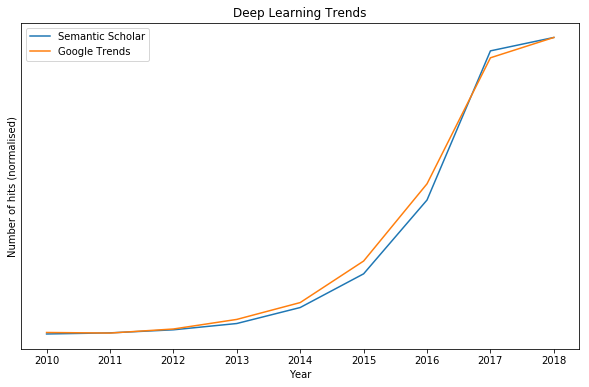

In [39]:
p = trends.plot(title = 'Deep Learning Trends', figsize=(10,6))
p.set_ylabel('Number of hits (normalised)')
p.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.savefig('../writing/figures/trends.pdf', bbox_inches='tight')

In [40]:
adult = pd.read_csv('../data/adult.csv')

In [45]:
adult_sample = adult.loc[:5,['age','occupation', 'education', 'race', 'sex', '>=50k']]

In [46]:
adult_sample.to_csv('../data/adult_sample.csv', index=None)

# Chapter 2

In [735]:
def f1(x):
    return x**2

def f2(x):
    return x**2+100#-x**2 + 40*x

In [736]:
x11 = np.arange(-18,18,0.5)
x12 = f1(x11)

x21 = np.arange(-18,18,0.5)
x22 = f2(x21)

In [737]:
x1 = np.concatenate([x11, x21])
x2 = np.concatenate([x12, x22])

In [738]:
X = np.hstack([x1[:,None], x2[:,None]]).astype(np.float32)
y = np.concatenate([np.zeros_like(x11), np.ones_like(x12)]).astype(np.int64)

In [739]:
X = (X-np.mean(X,0))/np.std(X,0)

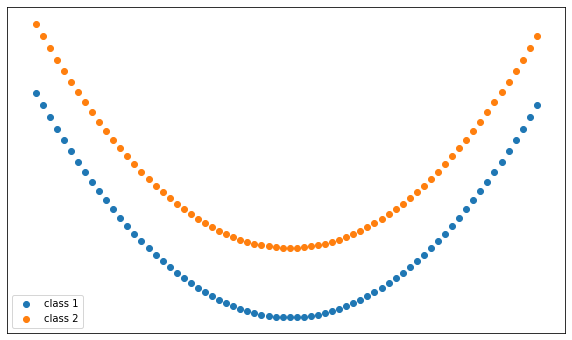

In [740]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X[y==0, 0], X[y==0,1], label='class 1')
ax.scatter(X[y==1, 0], X[y==1,1], label='class 2')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset.pdf', bbox_inches='tight')

In [741]:
from fastai import *

In [742]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

In [762]:
model = SimpleCNN()

In [763]:
ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
dl = DataLoader(dataset=ds, batch_size=8, shuffle=True)

In [764]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [765]:
tmp = []
for epoch in range(100):
    train_epoch(model, dl, optimizer, F.cross_entropy)
    tmp += [validate(model, dl, F.cross_entropy)]

In [766]:
tmp

[0.7070083,
 0.68736017,
 0.67096645,
 0.6571105,
 0.6455003,
 0.63576865,
 0.62746006,
 0.6204944,
 0.61451316,
 0.60948974,
 0.60520196,
 0.6015112,
 0.5983637,
 0.5956383,
 0.59328204,
 0.591258,
 0.5895051,
 0.58800465,
 0.58667254,
 0.58550334,
 0.5845122,
 0.5836408,
 0.58286107,
 0.58216125,
 0.5815747,
 0.58104825,
 0.5805977,
 0.5801836,
 0.5798254,
 0.5795048,
 0.57922375,
 0.57897794,
 0.57876056,
 0.57856405,
 0.57838225,
 0.5782162,
 0.5780746,
 0.5779481,
 0.57783264,
 0.57772756,
 0.577632,
 0.5775517,
 0.5774788,
 0.57741475,
 0.57735497,
 0.5773021,
 0.577255,
 0.5772135,
 0.5771748,
 0.577138,
 0.57710624,
 0.5770805,
 0.577055,
 0.5770326,
 0.57701343,
 0.5769958,
 0.57697856,
 0.5769625,
 0.57694864,
 0.57693607,
 0.57692415,
 0.5769151,
 0.57690793,
 0.5768988,
 0.57689154,
 0.5768859,
 0.5768788,
 0.5768729,
 0.57686824,
 0.5768636,
 0.57686055,
 0.57685685,
 0.57685316,
 0.5768499,
 0.5768474,
 0.5768445,
 0.57684255,
 0.57684046,
 0.57683843,
 0.57683665,
 0.576

In [767]:
X_mins = np.min(X, 0)*1.05
X_maxs = np.max(X, 0)*1.05

In [768]:
x1_all = np.arange(X_mins[0], X_maxs[0], (X_maxs[0]-X_mins[0])/100)
x2_all = np.arange(X_mins[1], X_maxs[1], (X_maxs[1]-X_mins[1])/100)

In [769]:
X_all = np.vstack(list(itertools.product(x1_all,x2_all))).astype(np.float32)

In [770]:
ds_all = TensorDataset(torch.from_numpy(X_all))
dl_all = DataLoader(dataset=ds_all, batch_size=32)

In [771]:
def get_shade_preds(model:nn.Module, dl:DataLoader)->None:
    model.eval()
    preds=[]
    for xb in dl:
        preds.append(model(xb[0]))
    preds = F.softmax(torch.cat(preds), 1)
    return np.array(preds)[:,1]

In [772]:
preds = get_shade_preds(model, dl_all)

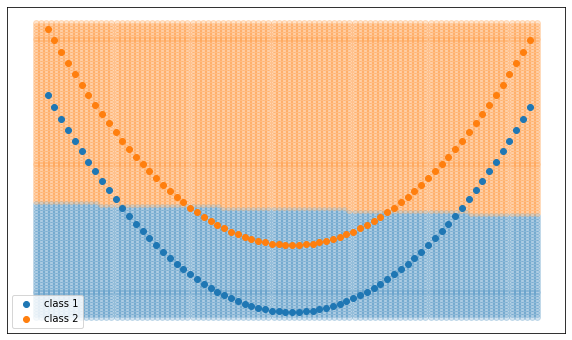

In [773]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_simpleNN.pdf', bbox_inches='tight')

In [774]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.a1 = nn.Sigmoid()
        self.fc2 = nn.Linear(2, 2)
#         self.a1 = nn.ReLU(inplace=True)
#         self.a1 = nn.Tanh()
    
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.fc2(x)
#         x = F.softmax(x, 1)
        return x

In [775]:
model = ComplexCNN()

In [776]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [777]:
tmp = []
for epoch in range(500):
    train_epoch(model, dl, optimizer, F.cross_entropy)
    tmp += [validate(model, dl, F.cross_entropy)]

In [778]:
tmp[::-10]

[0.025138553,
 0.025837064,
 0.026574181,
 0.027346127,
 0.028170738,
 0.029045114,
 0.029980494,
 0.030999072,
 0.032,
 0.03310212,
 0.034265358,
 0.03554596,
 0.036928132,
 0.038361046,
 0.039903514,
 0.04165916,
 0.04342869,
 0.04543801,
 0.04761281,
 0.050005157,
 0.05264668,
 0.055435658,
 0.058672607,
 0.06214829,
 0.06633951,
 0.070584625,
 0.075565904,
 0.08126688,
 0.08779623,
 0.09536476,
 0.104210414,
 0.114367515,
 0.12655716,
 0.14135729,
 0.15910406,
 0.1809752,
 0.20796904,
 0.2417779,
 0.28347495,
 0.3339602,
 0.39156124,
 0.4495926,
 0.49546322,
 0.5247022,
 0.54275155,
 0.55501616,
 0.5654971,
 0.57582164,
 0.59403586,
 0.63698494]

In [779]:
preds = get_shade_preds(model, dl_all)

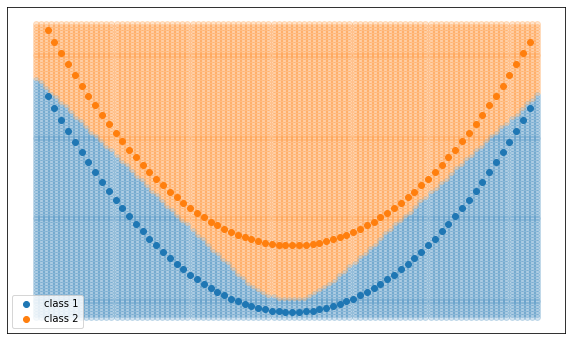

In [781]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(X[y==0,0], X[y==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(X[y==1,0], X[y==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_complexNN.pdf', bbox_inches='tight')

In [782]:
extractor=nn.Sequential(*[model.fc1, model.a1])

In [785]:
extractor.eval()
rep=[]
y_new=[]
for xb,yb in dl:
    rep += [extractor(xb)]
    y_new += [yb]
rep = np.array(torch.cat(rep))
y_new = np.array(torch.cat(y_new))

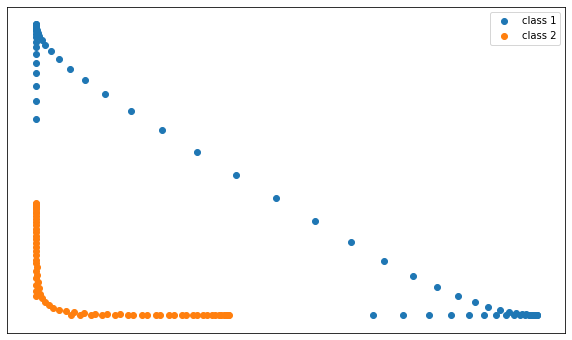

In [789]:
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(X_all[preds<0.5,0],X_all[preds<0.5,1], alpha=0.2, color=plt.cm.tab10(0))
# ax.scatter(X_all[preds>0.5,0],X_all[preds>0.5,1], alpha=0.2, color=plt.cm.tab10(1))
ax.scatter(rep[y_new==0,0], rep[y_new==0,1], label='class 1', color=plt.cm.tab10(0))
ax.scatter(rep[y_new==1,0], rep[y_new==1,1], label='class 2', color=plt.cm.tab10(1))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.savefig('../writing/figures/simple_dataset_complexNN_rep.pdf', bbox_inches='tight')

# Chapeter 6

## Cross-validation

In [4]:
from sklearn.model_selection import KFold

In [5]:
kf = KFold(5)

In [19]:
np.array(range(20)).shape

(20,)

In [20]:
next(iter(kf.split(np.array(range(20)))))

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([0, 1, 2, 3]))

In [63]:
def plot_cv_indices(cv, X, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    yticklabels = np.arange(1,n_splits+1)
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+.2, -.2], xlim=[0, 100])
    ax.set_title('5-fold Cross-Validation', fontsize=15)
    return ax

In [69]:
import matplotlib.patches as mpatches

In [74]:
hand = [mpatches.Patch(color=plt.cm.coolwarm(i+.2), label=sub) for i,sub in enumerate(['train', 'test'])]

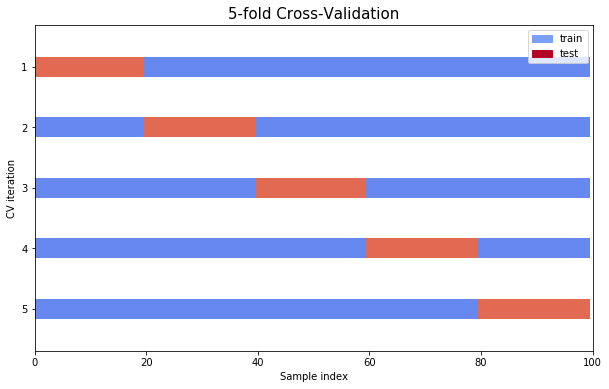

In [76]:
fig, ax = plt.subplots(figsize=(10,6))
plot_cv_indices(kf, np.array(range(100)), ax, 5, lw=20)
ax.legend(handles=hand)
plt.savefig('../writing/figures/cv.pdf', bbox_inches='tight')